# Market Impact Modeling and Optimal Execution

## 1. Overview

To design an optimal execution strategy, I first modelled the temporary market impact function \( g_t(x) \), which captures how executing a trade of size \( x \) at time \( t \) affects the price. I tested both **linear** and **nonlinear (power-law)** formulations and later used these fitted models for real-time online share allocation.

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import os
from tqdm import tqdm

## 2. Helper Function: Slippage Calculation

To evaluate the market impact of executing an order of size `x` at timestamp `t`, I computed the **slippage** as the average premium paid over the mid-price:

$$\text{Slippage}(x, t) = \frac{1}{x} \sum_{i=1}^{x} \left(P_{\text{exec},i} - P_{\text{mid}}(t)\right)$$

Where:
* $P_{\text{exec},i}$: execution price of the *i*-th share
* $P_{\text{mid}}(t)$: mid-price at timestamp *t*

This metric captures how far our execution deviates from the fair value, and forms the basis for modeling temporary market impact.

In [2]:
def compute_slippage(snapshot, order_sizes, side="sell"):
    bid_prices = [snapshot[f"bid_px_0{i}"] for i in range(10)]
    bid_sizes = [snapshot[f"bid_sz_0{i}"] for i in range(10)]
    ask_prices = [snapshot[f"ask_px_0{i}"] for i in range(10)]
    ask_sizes = [snapshot[f"ask_sz_0{i}"] for i in range(10)]

    best_bid = bid_prices[0]
    best_ask = ask_prices[0]
    mid_price = (best_bid + best_ask) / 2

    results = []
    for x in order_sizes:
        remaining = x
        total_value = 0
        filled = 0

        if side == "sell":
            for price, size in zip(bid_prices, bid_sizes):
                if remaining <= 0: break
                fill_qty = min(size, remaining)
                total_value += fill_qty * price
                remaining -= fill_qty
                filled += fill_qty
        else:  
            for price, size in zip(ask_prices, ask_sizes):
                if remaining <= 0: break
                fill_qty = min(size, remaining)
                total_value += fill_qty * price
                remaining -= fill_qty
                filled += fill_qty

        if filled > 0:
            avg_price = total_value / filled
            slippage = (avg_price - mid_price) if side == "buy" else (mid_price - avg_price)
        else:
            avg_price = 0
            slippage = 0

        results.append({
            "order_size": x,
            "avg_price": round(avg_price, 4),
            "slippage": round(slippage, 6),
            "side": side
        })
    return results


## 3. Data Preparation and Slippage Estimation

The original CSV files had **nanosecond-level timestamps** and were not uniformly spaced, so I refactored them into **~1-minute snapshots** for better temporal consistency.

I also calculated the **total liquidity** at each timestamp to decide the appropriate range of order sizes \( X \) for modeling.  
For each timestamp and order size, I computed the average execution price and then estimated the **slippage** using the `compute_slippage` function.

These raw slippage estimates — including the timestamp, ticker, order size, average price, slippage, and side — were stored in files like:  
`<ticker>.output.csv` (e.g., `CRWV.output.csv`, `SOUN.output.csv`).

This slippage dataset was later used to fit both the **linear** and **nonlinear (power-law)** models of temporary market impact, whose fitted coefficients and \( R^2 \) scores were saved separately.


In [3]:
from glob import glob
import pandas as pd
from tqdm import tqdm

tickers = ["CRWV", "FROG", "SOUN"]
order_sizes = [10, 50, 100, 200, 500, 1000, 2000, 5000]
target_date = "2025-04-03"
base_path = "."

target_date_obj = pd.to_datetime(target_date).date()

import os
for ticker in tickers:
    out_file = f"{ticker}_output.csv"
    if os.path.exists(out_file):
        os.remove(out_file)

for ticker in tickers:
    print(f" Processing {ticker} for {target_date}...")
    csv_files = glob(f"{base_path}/{ticker}/*.csv")
    output_rows = []

    for csv_file in tqdm(csv_files, desc=f"{ticker} files"):
        try:
            df = pd.read_csv(csv_file)
            df["ts_event"] = pd.to_datetime(df["ts_event"], errors="coerce")
            df = df.dropna(subset=["ts_event"])

            df = df[df["ts_event"].dt.date == target_date_obj]
            if df.empty:
                continue

            df = df.set_index("ts_event")

            df["total_bid_liquidity"] = sum(df[f"bid_sz_0{i}"] for i in range(10))
            df["total_ask_liquidity"] = sum(df[f"ask_sz_0{i}"] for i in range(10))

            df_1min = df.resample("1min").first().dropna().reset_index()
            df_1min["ts_event"] = df_1min["ts_event"].dt.floor("min")

            for _, row in df_1min.iterrows():
                for side in ["sell", "buy"]:
                    slippages = compute_slippage(row, order_sizes, side)
                    for s in slippages:
                        output_rows.append({
                            "timestamp": row["ts_event"],
                            "ticker": ticker,
                            "order_size": s["order_size"],
                            "avg_price": s["avg_price"],
                            "slippage": s["slippage"],
                            "side": s["side"]
                        })

        except Exception as e:
            print(f" Error processing {csv_file}: {e}")

    output_df = pd.DataFrame(output_rows)
    output_df.to_csv(f"{ticker}_output.csv", index=False)
    print(f" Saved {ticker}_output.csv with {len(output_df)} rows.")


 Processing CRWV for 2025-04-03...


CRWV files: 100%|██████████| 1/1 [00:01<00:00,  1.53s/it]


 Saved CRWV_output.csv with 6240 rows.
 Processing FROG for 2025-04-03...


FROG files: 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]


 Saved FROG_output.csv with 6240 rows.
 Processing SOUN for 2025-04-03...


SOUN files: 100%|██████████| 1/1 [00:04<00:00,  4.18s/it]

 Saved SOUN_output.csv with 6240 rows.


## 4. Slippage vs Order Size — Model Fit for Single Snapshots

To qualitatively evaluate how well each market impact model fits real trading data, I visualized the slippage $g_t(x)$ against order size $x$ for a **single timestamp snapshot** from each ticker.

This allowed us to compare the **linear** and **nonlinear (power-law)** fits visually and through their respective $R^2$ scores.

The plot includes:
* Actual slippage data points (black dots)
* Linear fit: $g_t(x) = a_t \cdot x$
* Power-law fit: $g_t(x) = \exp(c_t \cdot \log(x)) = x^{c_t}$

In [4]:
def plot_single_snapshot_fit(df_snap, timestamp, side='sell'):
    from sklearn.linear_model import LinearRegression
    import numpy as np
    import matplotlib.pyplot as plt

    X = df_snap["order_size"].values.reshape(-1, 1)
    y = df_snap["slippage"].values

    lin_model = LinearRegression().fit(X, y)
    y_lin_pred = lin_model.predict(X)
    r2_lin = r2_score(y, y_lin_pred)

    try:
        logX = np.log(X)
        logy = np.log(y)
        log_model = LinearRegression().fit(logX, logy)
        y_log_pred = np.exp(log_model.predict(logX))
        r2_pow = r2_score(y, y_log_pred)
    except:
        y_log_pred = np.zeros_like(y)
        r2_pow = 0

    plt.figure(figsize=(8, 5))
    plt.scatter(X, y, color='black', label="True Data")
    plt.plot(X, y_lin_pred, color='blue', label=f"Linear Fit (R²={r2_lin:.4f})")
    plt.plot(X, y_log_pred, color='green', label=f"Power Law Fit (R²={r2_pow:.4f})")
    plt.xlabel("Order Size (x)")
    plt.ylabel("Slippage gₜ(x)")
    plt.title(f"Temporary Impact Models @ {timestamp}\n({side.capitalize()} Side)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## 5. Slippage vs Order Size Plot (Single Snapshot)

To visualize the temporary market impact model fits, I plotted slippage versus order size for the **first timestamp** from each ticker. This helps illustrate how well both **linear** and **power-law** models capture the relationship between order size and slippage.

For each ticker (`CRWV`, `FROG`, and `SOUN`), I:
- Loaded the `*_output.csv` file,
- Extracted the first unique timestamp,
- Filtered the snapshot for both **buy** and **sell** sides separately,
- And called the `plot_single_snapshot_fit` function for each.

If data was missing for a side at the first timestamp, it was skipped with a warning.

This quick visual check was crucial in confirming that power-law often better captures nonlinear slippage trends, especially at larger order sizes.



 Plotting for: CRWV


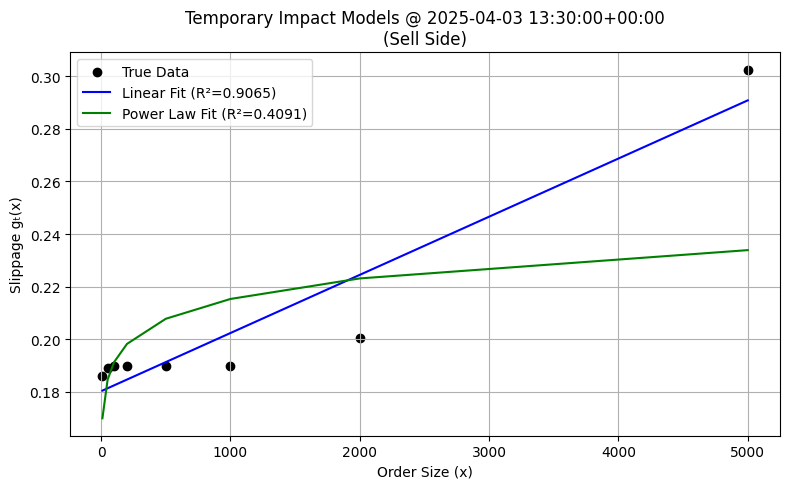

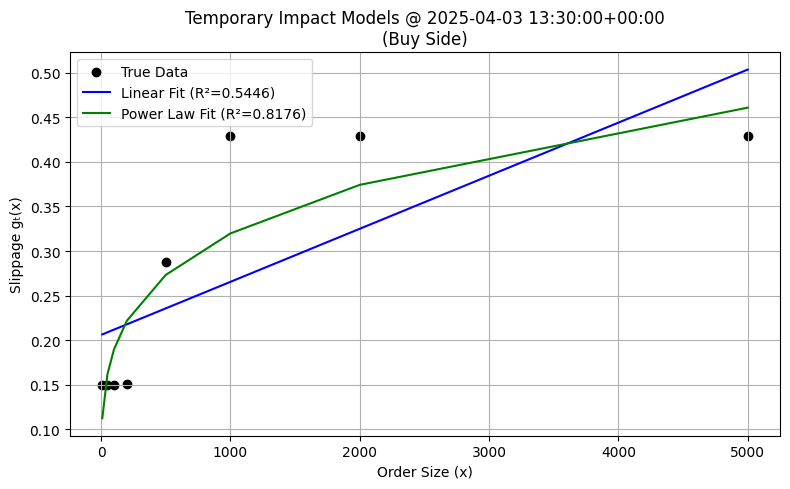


 Plotting for: FROG


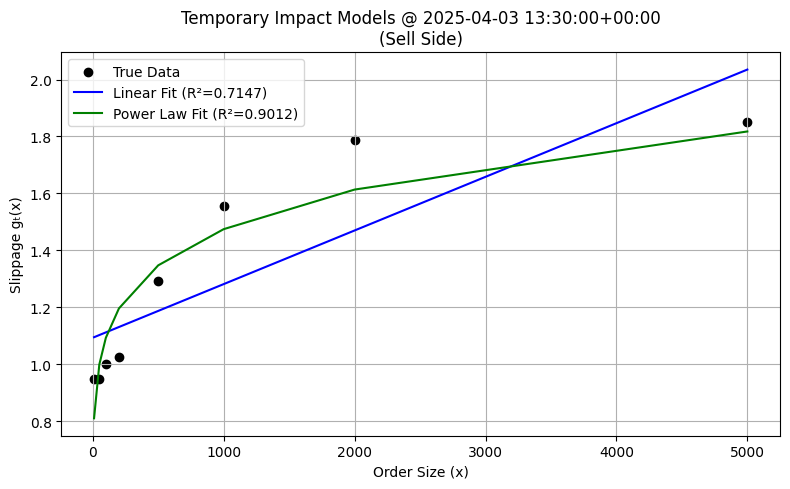

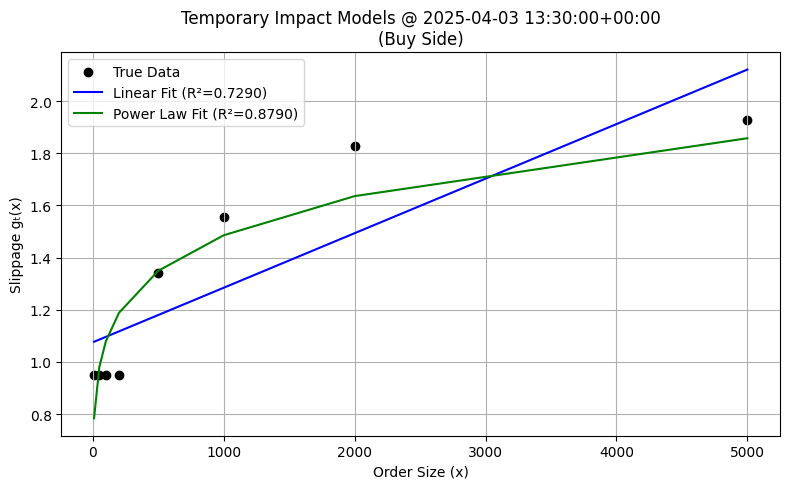


 Plotting for: SOUN


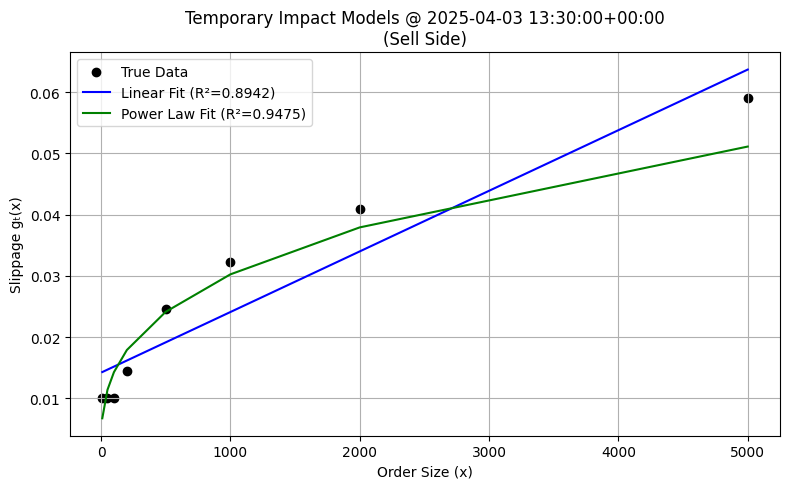

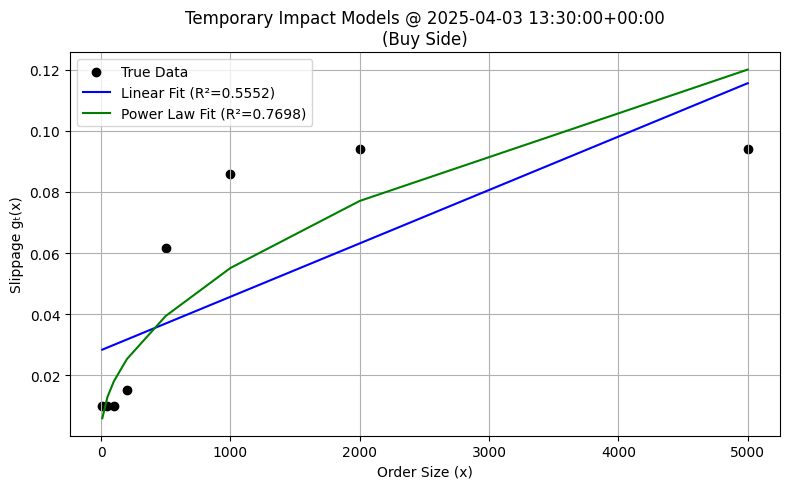

In [5]:
tickers = ["CRWV", "FROG", "SOUN"]
    
for ticker in tickers:
    print(f"\n Plotting for: {ticker}")
    df = pd.read_csv(f"{ticker}_output.csv")
    
    first_ts = df["timestamp"].unique()[0]
    
    for side in ["sell", "buy"]:
        snap = df[(df["timestamp"] == first_ts) & (df["side"] == side)]
        if len(snap) > 0:
            plot_single_snapshot_fit(snap, first_ts, side=side)
        else:
            print(f" No data for {side} side at {first_ts} in {ticker}")



## 6. R² Score Comparison Over Time (Sell Side)

To evaluate model performance over time, I computed and plotted the **R² scores** of both **linear** and **power-law** fits for the **sell side** across all timestamps for each ticker (`CRWV`, `FROG`, and `SOUN`).

For each 1-minute snapshot:
- I grouped the data by timestamp and filtered for the sell side.
- Snapshots with fewer than 3 data points or with all-zero slippage were skipped.
- A linear model was fit using raw `order_size` vs `slippage`.
- A power-law model was fit by applying a log-log transformation (`log(order_size)` vs `log(slippage)`), and the predicted values were exponentiated.
- R² scores were computed for both models and stored over time.

Finally, I plotted the R² scores across all snapshots to observe how model performance varies with time. This visualization helps identify whether the power-law consistently outperforms the linear model in modeling slippage across timestamps.



🔍 Plotting R² Scores for CRWV — Sell side


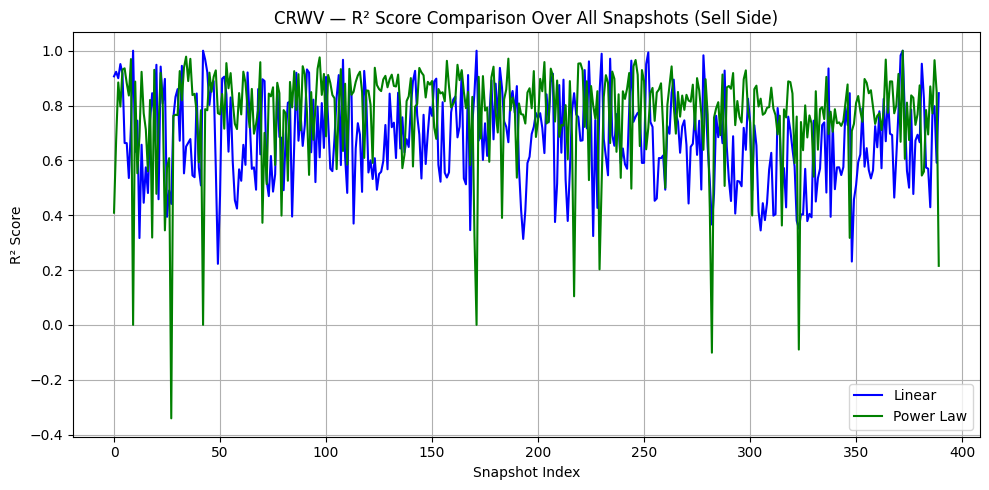


🔍 Plotting R² Scores for FROG — Sell side


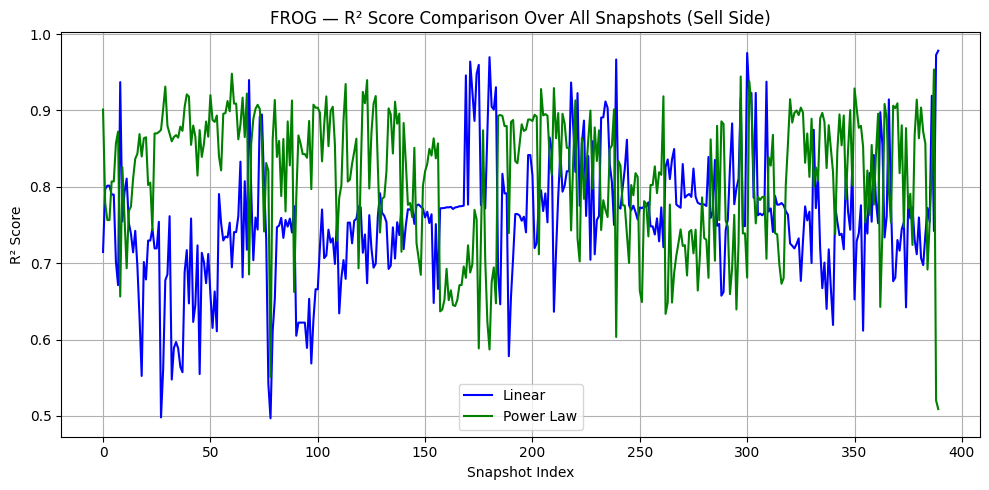


🔍 Plotting R² Scores for SOUN — Sell side


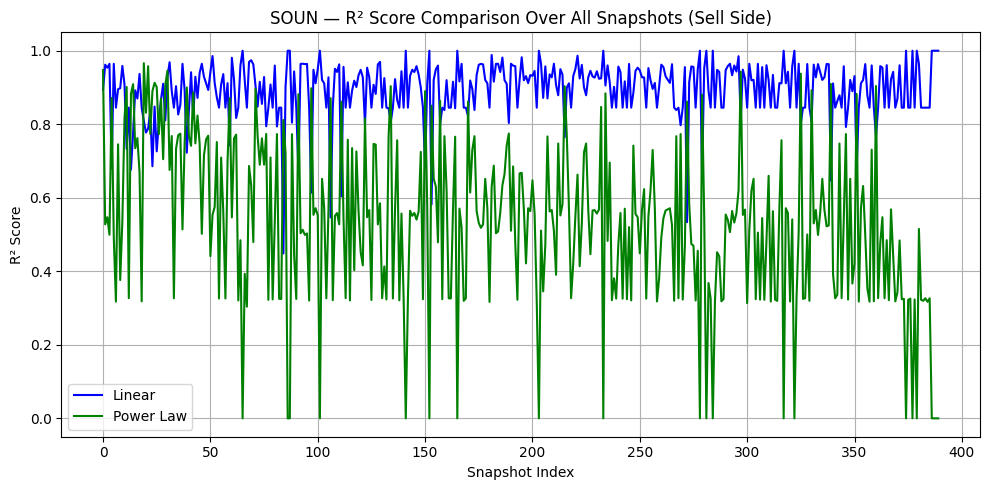

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

tickers = ["CRWV", "FROG", "SOUN"]
side = "sell" 

for ticker in tickers:
    print(f"\n🔍 Plotting R² Scores for {ticker} — {side.capitalize()} side")

    df = pd.read_csv(f"{ticker}_output.csv")
    df["timestamp"] = pd.to_datetime(df["timestamp"])

    df_side = df[df["side"] == side]
    grouped = df_side.groupby("timestamp")

    r2_lin_list = []
    r2_pow_list = []
    timestamps = []

    for timestamp, snap in grouped:
        if len(snap) < 3:
            continue

        X = snap["order_size"].values.reshape(-1, 1)
        y = snap["slippage"].values

        if np.all(y == 0):
            continue

        lin_model = LinearRegression().fit(X, y)
        r2_lin = r2_score(y, lin_model.predict(X))

        try:
            logX = np.log(X)
            logy = np.log(y)
            log_model = LinearRegression().fit(logX, logy)
            y_pred_log = np.exp(log_model.predict(logX))
            r2_pow = r2_score(y, y_pred_log)
        except:
            r2_pow = 0

        r2_lin_list.append(r2_lin)
        r2_pow_list.append(r2_pow)
        timestamps.append(timestamp)

    plt.figure(figsize=(10, 5))
    plt.plot(r2_lin_list, label="Linear", color="blue")
    plt.plot(r2_pow_list, label="Power Law", color="green")
    plt.title(f"{ticker} — R² Score Comparison Over All Snapshots ({side.capitalize()} Side)")
    plt.xlabel("Snapshot Index")
    plt.ylabel("R² Score")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


## 7. R² Score Comparison Over Time (Buy Side)

Similar to the sell side, to evaluate model performance over time, I computed and plotted the **R² scores** of both **linear** and **power-law** fits for the **buy side** across all timestamps for each ticker (`CRWV`, `FROG`, and `SOUN`).

Finally, I plotted the R² scores across all snapshots to observe how model performance varies with time. This visualization helps identify whether the power-law consistently outperforms the linear model in modeling slippage across timestamps. We can observe that for each ticker the performance of both the models is very different and neither dominates all. 



🔍 Plotting R² Scores for CRWV — Buy side


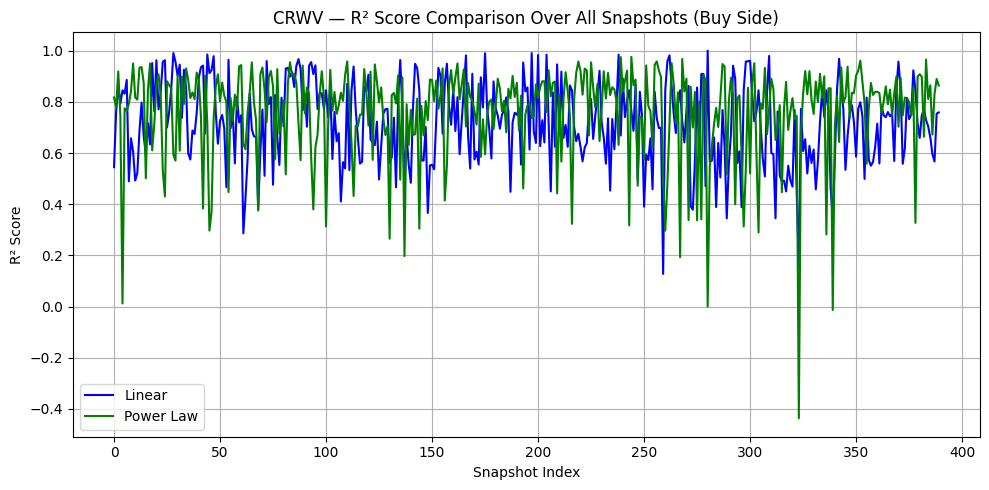


🔍 Plotting R² Scores for FROG — Buy side


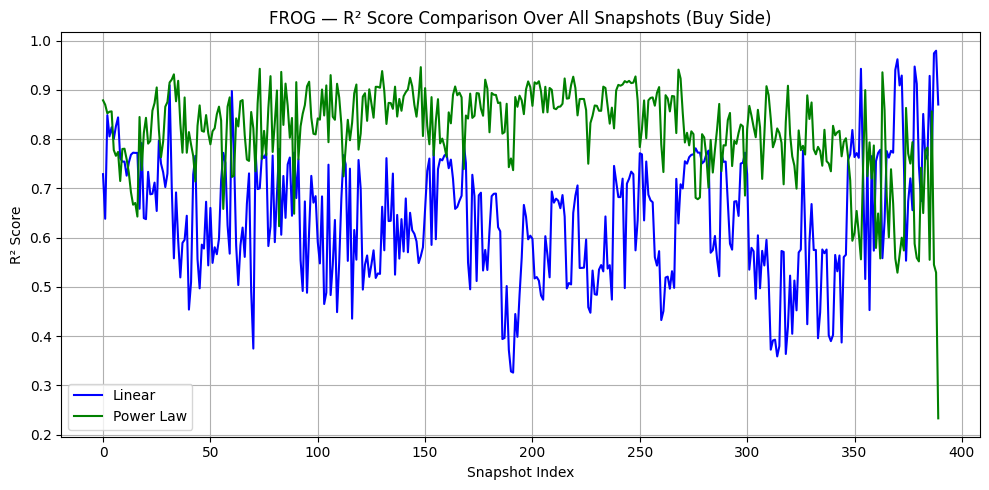


🔍 Plotting R² Scores for SOUN — Buy side


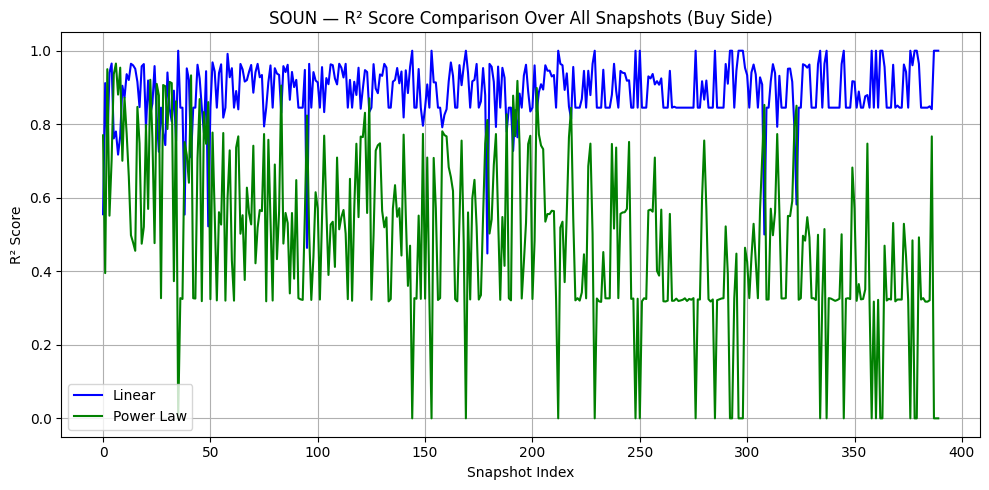

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

tickers = ["CRWV", "FROG", "SOUN"]
side = "buy" 

for ticker in tickers:
    print(f"\n🔍 Plotting R² Scores for {ticker} — {side.capitalize()} side")

    df = pd.read_csv(f"{ticker}_output.csv")
    df["timestamp"] = pd.to_datetime(df["timestamp"])

    df_side = df[df["side"] == side]
    grouped = df_side.groupby("timestamp")

    r2_lin_list = []
    r2_pow_list = []
    timestamps = []

    for timestamp, snap in grouped:
        if len(snap) < 3:
            continue

        X = snap["order_size"].values.reshape(-1, 1)
        y = snap["slippage"].values

        if np.all(y == 0):
            continue

        lin_model = LinearRegression().fit(X, y)
        r2_lin = r2_score(y, lin_model.predict(X))

        try:
            logX = np.log(X)
            logy = np.log(y)
            log_model = LinearRegression().fit(logX, logy)
            y_pred_log = np.exp(log_model.predict(logX))
            r2_pow = r2_score(y, y_pred_log)
        except:
            r2_pow = 0

        r2_lin_list.append(r2_lin)
        r2_pow_list.append(r2_pow)
        timestamps.append(timestamp)

    plt.figure(figsize=(10, 5))
    plt.plot(r2_lin_list, label="Linear", color="blue")
    plt.plot(r2_pow_list, label="Power Law", color="green")
    plt.title(f"{ticker} — R² Score Comparison Over All Snapshots ({side.capitalize()} Side)")
    plt.xlabel("Snapshot Index")
    plt.ylabel("R² Score")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


## 8. Extracting Model Coefficients (Sell Side)

Now that we have observed real fluctuations in the market impact using our models, it's time to extract the fitted coefficients for both the **linear** and **power-law** models — starting with the **sell side**.

For each 1-minute snapshot in every ticker (`CRWV`, `FROG`, `SOUN`), the following steps were performed:

- **Filtering**: Only sell side data was used. Snapshots with fewer than 3 data points or all-zero slippage were skipped.
- **Linear Model Fit**:
  - Fit `slippage = aₜ·x + bₜ` using `order_size` as the input.
  - Stored the coefficients `aₜ`, `bₜ` and the R² score of the fit.
- **Power-Law Fit**:
  - Fit `slippage = cₜ·x^dₜ` using log-log transformation.
  - Extracted `cₜ`, `dₜ`, and computed the R² score of the power-law fit.

These coefficients are stored with timestamp granularity in separate CSV files for each ticker:


In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np
import pandas as pd
from tqdm import tqdm

tickers = ["CRWV", "FROG", "SOUN"]
side = "sell" 

for ticker in tickers:
    print(f"\n Fitting models for: {ticker} ({side} side)")

    df = pd.read_csv(f"{ticker}_output.csv")
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df_side = df[df["side"] == side]
    grouped = df_side.groupby("timestamp")

    model_rows = []

    for timestamp, snap in tqdm(grouped, desc=f"{ticker} snapshots"):
        if len(snap) < 3 or np.all(snap["slippage"] == 0):
            continue

        X = snap["order_size"].values.reshape(-1, 1)
        y = snap["slippage"].values

        lin_model = LinearRegression().fit(X, y)
        a_t = lin_model.coef_[0]
        b_t = lin_model.intercept_
        r2_lin = r2_score(y, lin_model.predict(X))

        try:
            logX = np.log(X)
            logy = np.log(y)
            log_model = LinearRegression().fit(logX, logy)
            d_t = log_model.coef_[0]
            log_c_t = log_model.intercept_
            c_t = np.exp(log_c_t)
            y_pred_log = np.exp(log_model.predict(logX))
            r2_pow = r2_score(y, y_pred_log)
        except:
            c_t = 0
            d_t = 0
            r2_pow = 0

        model_rows.append({
            "timestamp": timestamp,
            "a_t": a_t,
            "b_t": b_t,
            "r2_lin": r2_lin,
            "c_t": c_t,
            "d_t": d_t,
            "r2_pow": r2_pow
        })

    model_df = pd.DataFrame(model_rows)
    model_df.to_csv(f"{ticker}_model_coeffs_{side}.csv", index=False)
    print(f" Saved: {ticker}_model_coeffs_{side}.csv")



 Fitting models for: CRWV (sell side)


CRWV snapshots:   0%|          | 0/390 [00:00<?, ?it/s]

CRWV snapshots: 100%|██████████| 390/390 [00:00<00:00, 537.58it/s]


 Saved: CRWV_model_coeffs_sell.csv

 Fitting models for: FROG (sell side)


FROG snapshots: 100%|██████████| 390/390 [00:01<00:00, 379.33it/s]


 Saved: FROG_model_coeffs_sell.csv

 Fitting models for: SOUN (sell side)


SOUN snapshots: 100%|██████████| 390/390 [00:01<00:00, 288.22it/s]

 Saved: SOUN_model_coeffs_sell.csv


## 9. Extracting Model Coefficients (Buy Side)

Now let's similarly extract the coefficients for the buy side.
These coefficients are stored with timestamp granularity in separate CSV files for each ticker:


In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np
import pandas as pd
from tqdm import tqdm

tickers = ["CRWV", "FROG", "SOUN"]
side = "buy" 

for ticker in tickers:
    print(f"\n Fitting models for: {ticker} ({side} side)")

    df = pd.read_csv(f"{ticker}_output.csv")
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df_side = df[df["side"] == side]
    grouped = df_side.groupby("timestamp")

    model_rows = []

    for timestamp, snap in tqdm(grouped, desc=f"{ticker} snapshots"):
        if len(snap) < 3 or np.all(snap["slippage"] == 0):
            continue

        X = snap["order_size"].values.reshape(-1, 1)
        y = snap["slippage"].values

        lin_model = LinearRegression().fit(X, y)
        a_t = lin_model.coef_[0]
        b_t = lin_model.intercept_
        r2_lin = r2_score(y, lin_model.predict(X))

        try:
            logX = np.log(X)
            logy = np.log(y)
            log_model = LinearRegression().fit(logX, logy)
            d_t = log_model.coef_[0]
            log_c_t = log_model.intercept_
            c_t = np.exp(log_c_t)
            y_pred_log = np.exp(log_model.predict(logX))
            r2_pow = r2_score(y, y_pred_log)
        except:
            c_t = 0
            d_t = 0
            r2_pow = 0

        model_rows.append({
            "timestamp": timestamp,
            "a_t": a_t,
            "b_t": b_t,
            "r2_lin": r2_lin,
            "c_t": c_t,
            "d_t": d_t,
            "r2_pow": r2_pow
        })

    model_df = pd.DataFrame(model_rows)
    model_df.to_csv(f"{ticker}_model_coeffs_{side}.csv", index=False)
    print(f" Saved: {ticker}_model_coeffs_{side}.csv")



 Fitting models for: CRWV (buy side)


CRWV snapshots: 100%|██████████| 390/390 [00:00<00:00, 465.44it/s]


 Saved: CRWV_model_coeffs_buy.csv

 Fitting models for: FROG (buy side)


FROG snapshots: 100%|██████████| 390/390 [00:01<00:00, 321.83it/s]


 Saved: FROG_model_coeffs_buy.csv

 Fitting models for: SOUN (buy side)


SOUN snapshots: 100%|██████████| 390/390 [00:01<00:00, 344.55it/s]

 Saved: SOUN_model_coeffs_buy.csv


## 10. Optimal Allocation & Market Impact Comparison

With the model coefficients extracted, the next step was to **optimize the share allocation** across timestamps to minimize the total market impact. This optimization was performed separately for both the **Linear** and **Power Law** models.

For each ticker (`CRWV`, `FROG`, `SOUN`), the following steps were carried out:

- **Visualization of Coefficients**:  
  I plotted the time series of model coefficients:
  - Linear model: `aₜ`, `bₜ`
  - Power law model: `cₜ`, `dₜ`
  This helped observe how each parameter evolved over time and ensured model stability.

- **Optimization Objective**:  
  Using the extracted coefficients, I minimized the total impact for a fixed order size `S`:
  - **Linear model**:  
    $$\text{Minimize} \quad \sum_t (a_t \cdot x_t + b_t)$$
  - **Power Law model**:  
    $$\text{Minimize} \quad \sum_t (c_t \cdot x_t^{d_t})$$  
  Subject to the constraint:  
    $$\sum_t x_t = S$$

- **Chosen Order Sizes `S`**:  
  The value of `S` for each ticker was based on earlier liquidity observations and coefficient ranges and the ease of plotting:
  - `CRWV`: 90,000 shares
  - `FROG`: 80,000 shares
  - `SOUN`: 1,500 shares

- **Resulting Plots**:
  - Optimal allocation over timestamps for both models.
  - Total market impact comparison between linear and power law fits.
  - Visual indication of which model resulted in lower market impact.

These results provided a clear picture of how allocation decisions vary under different market impact assumptions and helped finalize the preferred model for each ticker.



 Analyzing: CRWV


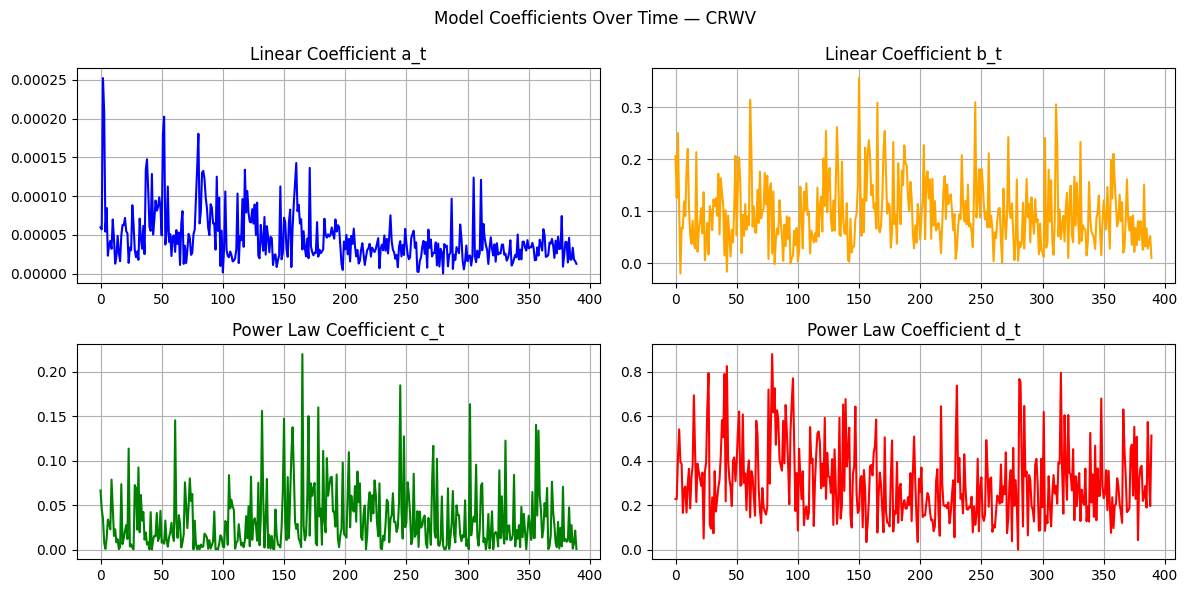

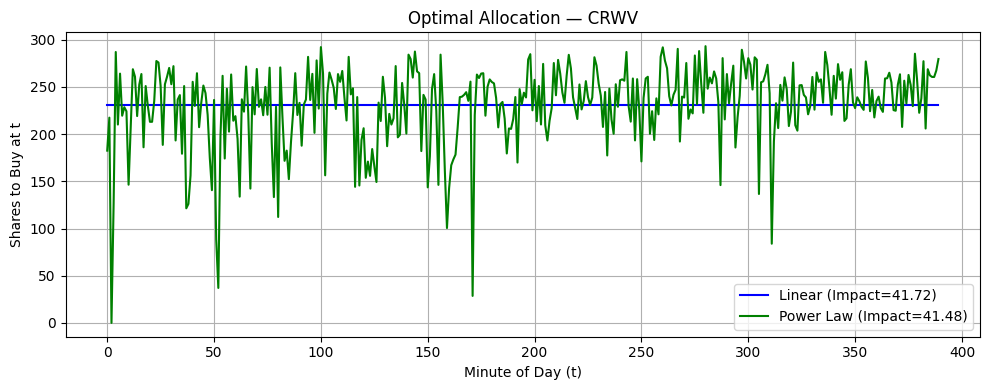


 Optimization Results for CRWV:
Linear Model: Success=True, Total Impact=41.72
Power Law  : Success=True, Total Impact=41.48
 Best model: Power Law


 Analyzing: FROG


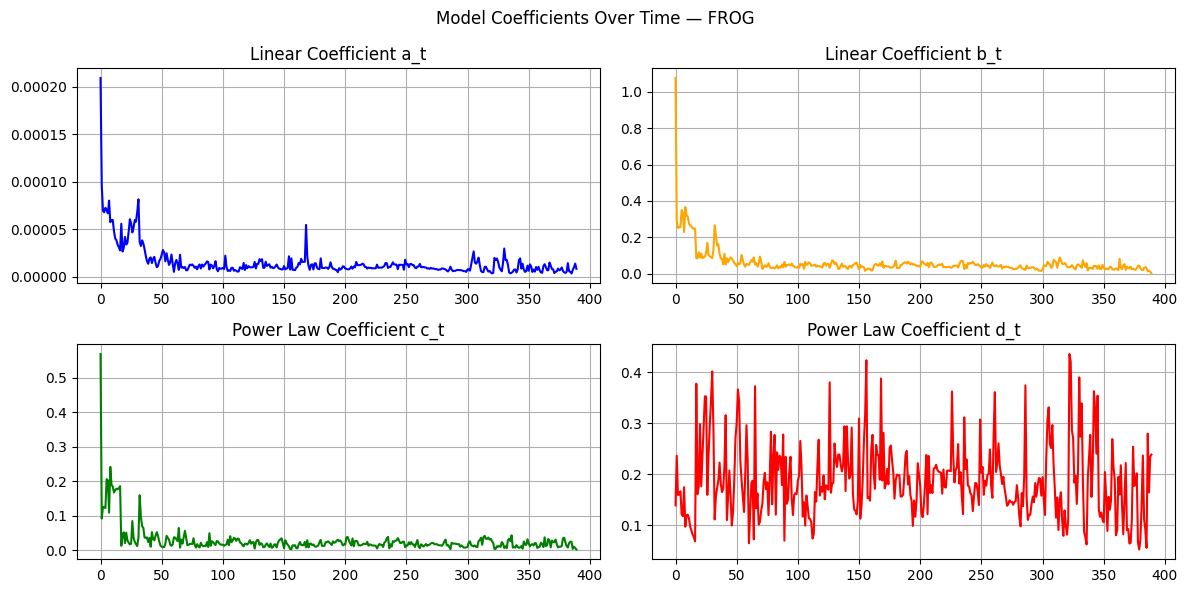

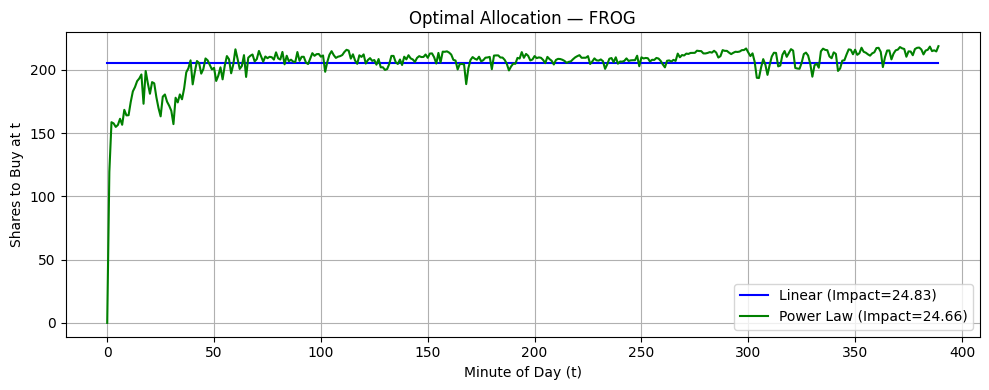


 Optimization Results for FROG:
Linear Model: Success=True, Total Impact=24.83
Power Law  : Success=False, Total Impact=24.66
 Best model: Power Law


 Analyzing: SOUN


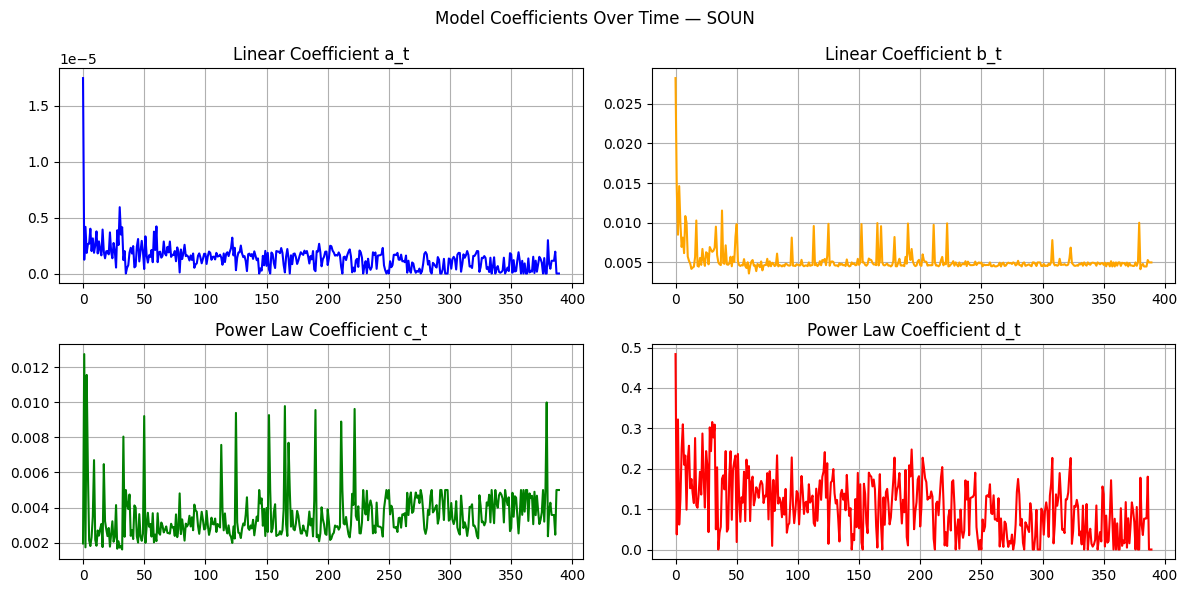

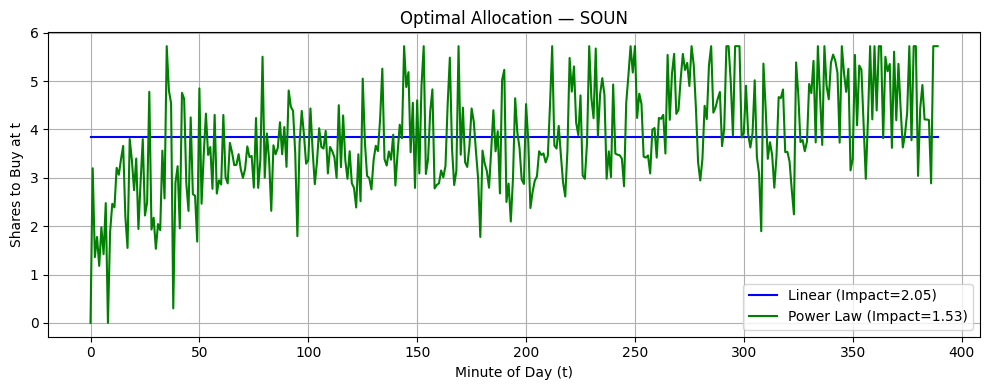


 Optimization Results for SOUN:
Linear Model: Success=True, Total Impact=2.05
Power Law  : Success=False, Total Impact=1.53
 Best model: Power Law



In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

tickers = ["CRWV", "FROG", "SOUN"]
S_dict = {"CRWV": 90000, "FROG": 80000, "SOUN": 1500} # Change it to test for different order sizes

def impact_linear(x, a_t, b_t):
    return np.sum(a_t * x + b_t)

def impact_power(x, c_t, d_t):
    return np.sum(c_t * x**d_t)

def optimize_allocation(model_func, coeff_args, S):
    bounds = [(0, None)] * len(coeff_args[0])
    x0 = np.full(len(coeff_args[0]), S / len(coeff_args[0]))
    constraints = [{"type": "eq", "fun": lambda x: np.sum(x) - S}]

    res = minimize(
        model_func,
        x0,
        args=coeff_args,
        method="SLSQP",
        bounds=bounds,
        constraints=constraints,
        options={"disp": False}
    )
    return res.x, model_func(res.x, *coeff_args), res.success

for ticker in tickers:
    print(f"\n Analyzing: {ticker}")
    coeff_df = pd.read_csv(f"{ticker}_model_coeffs_buy.csv").dropna()

    fig, axs = plt.subplots(2, 2, figsize=(12, 6))
    axs[0, 0].plot(coeff_df["a_t"], label="a_t (slope)", color="blue")
    axs[0, 0].set_title("Linear Coefficient a_t")

    axs[0, 1].plot(coeff_df["b_t"], label="b_t (intercept)", color="orange")
    axs[0, 1].set_title("Linear Coefficient b_t")

    axs[1, 0].plot(coeff_df["c_t"], label="c_t (scale)", color="green")
    axs[1, 0].set_title("Power Law Coefficient c_t")

    axs[1, 1].plot(coeff_df["d_t"], label="d_t (exponent)", color="red")
    axs[1, 1].set_title("Power Law Coefficient d_t")

    for ax in axs.flat:
        ax.grid(True)
    plt.suptitle(f"Model Coefficients Over Time — {ticker}")
    plt.tight_layout()
    plt.show()

    a_t = coeff_df["a_t"].values
    b_t = coeff_df["b_t"].values
    c_t = coeff_df["c_t"].values
    d_t = coeff_df["d_t"].values

    S = S_dict[ticker]

    x_lin, impact_lin, success_lin = optimize_allocation(impact_linear, (a_t, b_t), S)

    x_pow, impact_pow, success_pow = optimize_allocation(impact_power, (c_t, d_t), S)

    plt.figure(figsize=(10, 4))
    plt.plot(x_lin, label=f"Linear (Impact={impact_lin:.2f})", color="blue")
    plt.plot(x_pow, label=f"Power Law (Impact={impact_pow:.2f})", color="green")
    plt.title(f"Optimal Allocation — {ticker}")
    plt.xlabel("Minute of Day (t)")
    plt.ylabel("Shares to Buy at t")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"\n Optimization Results for {ticker}:")
    print(f"Linear Model: Success={success_lin}, Total Impact={impact_lin:.2f}")
    print(f"Power Law  : Success={success_pow}, Total Impact={impact_pow:.2f}")
    better = "Power Law" if impact_pow < impact_lin else "Linear"
    print(f" Best model: {better}\n")


## 11. Linear vs Power-Law — When Does Each Win?

While the **Power Law** often outperforms the **Linear Model** in the fitting phase, it's not always the optimal choice. To better understand their trade-offs, we compare **minimized market impact** under both models for varying total buy sizes (`S`).

I used the fitted coefficients (`aₜ`, `bₜ`, `cₜ`, `dₜ`) from each ticker’s **buy-side CSVs**, and for each value of `S`, we solve:

- **Linear Allocation**:  
  Minimize ∑ *(aₜ·xₜ + bₜ)* subject to ∑xₜ = S
- **Power Law Allocation**:  
  Minimize ∑ *(cₜ·xₜᵈₜ)* subject to ∑xₜ = S

Plots below show results for different `S` values across tickers:

- X-axis: Total shares to buy (`S`)
- Y-axis: Minimized market impact

Each model yields lower market impact in different regimes — showing that no single model always dominates. Power Law tends to outperform for smaller S due to its nonlinear nature, while Linear may be more effective for larger orders.



 Comparing Linear vs Power — CRWV


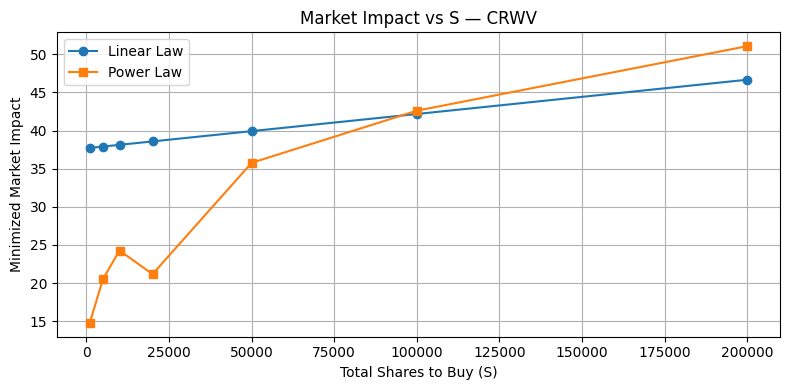


 Comparing Linear vs Power — FROG


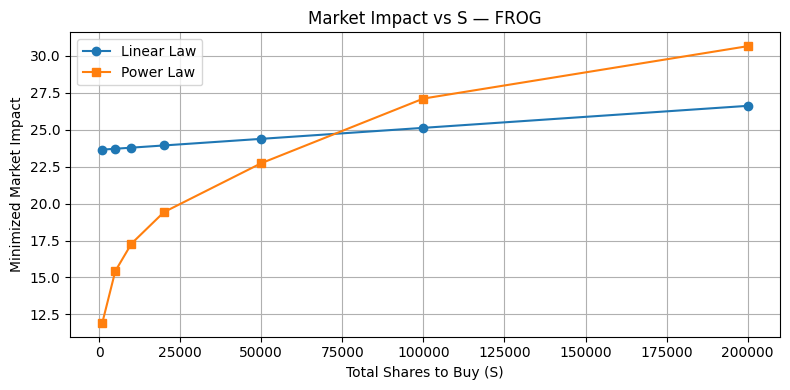


 Comparing Linear vs Power — SOUN


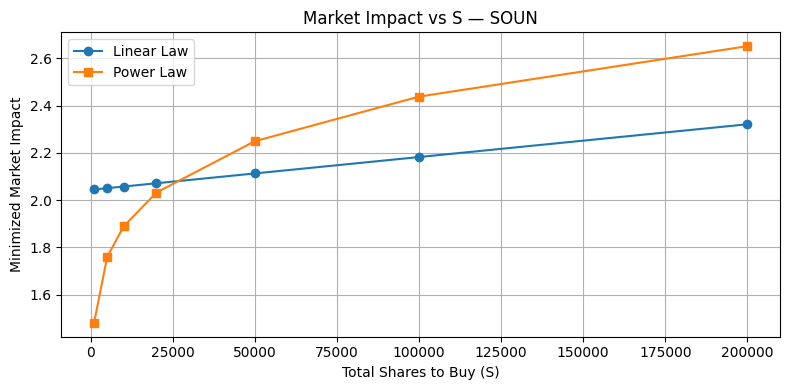

In [11]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

tickers = ["CRWV", "FROG", "SOUN"]
S_values = [1_000, 5_000, 10_000, 20_000, 50_000, 100_000, 200_000]

def impact_linear(x, a_t, b_t):
    return np.sum(a_t * x + b_t)

def impact_power(x, c_t, d_t):
    return np.sum(c_t * x**d_t)

def minimize_linear(S, a_t, b_t):
    x0 = np.full_like(a_t, S / len(a_t))
    bounds = [(0, None)] * len(a_t)
    constraints = [{"type": "eq", "fun": lambda x: np.sum(x) - S}]
    res = minimize(impact_linear, x0, args=(a_t, b_t), method="SLSQP", bounds=bounds, constraints=constraints)
    return impact_linear(res.x, a_t, b_t)

def minimize_power(S, c_t, d_t):
    x0 = np.full_like(c_t, S / len(c_t))
    bounds = [(0, None)] * len(c_t)
    constraints = [{"type": "eq", "fun": lambda x: np.sum(x) - S}]
    res = minimize(impact_power, x0, args=(c_t, d_t), method="SLSQP", bounds=bounds, constraints=constraints)
    return impact_power(res.x, c_t, d_t)

for ticker in tickers:
    print(f"\n Comparing Linear vs Power — {ticker}")
    df = pd.read_csv(f"{ticker}_model_coeffs_buy.csv").dropna()

    a_t = df["a_t"].values
    b_t = df["b_t"].values
    c_t = df["c_t"].values
    d_t = df["d_t"].values

    linear_impacts = []
    power_impacts = []

    for S in S_values:
        imp_lin = minimize_linear(S, a_t, b_t)
        imp_pow = minimize_power(S, c_t, d_t)
        linear_impacts.append(imp_lin)
        power_impacts.append(imp_pow)

    plt.figure(figsize=(8, 4))
    plt.plot(S_values, linear_impacts, label="Linear Law", marker='o')
    plt.plot(S_values, power_impacts, label="Power Law", marker='s')
    plt.title(f"Market Impact vs S — {ticker}")
    plt.xlabel("Total Shares to Buy (S)")
    plt.ylabel("Minimized Market Impact")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


## 12. Final Allocation Results (Buy Side Only)

Now I will perform greedy allocation of **S = 100,000** shares using both fitted **Linear** and **Power Law** models on the **buy side**. For each ticker, I used minute-level coefficients (`aₜ`, `bₜ`, `cₜ`, `dₜ`) from the buy-side CSVs and computed:

- **Linear Allocation**:  
  Greedily allocate based on cost = *(aₜ·1 + bₜ)* per unit
- **Power Law Allocation**:  
  Greedily allocate based on cost = *(cₜ·1ᵈₜ)* per unit

I then calculated the **total market impact** for both allocations.

This confirms that **Power Law and Linear models lead to different execution outcomes**, and the preferred model may vary across tickers depending on coefficient behavior over time.


In [12]:
import pandas as pd
import numpy as np

tickers = ["CRWV", "FROG", "SOUN"]
S = 100000  # Total shares to buy

def compute_power_law_impact(x, c_t, d_t):
    return np.sum(c_t * x**d_t)

def compute_linear_law_impact(x, a_t, b_t):
    return np.sum(a_t * x + b_t)

def power_law_greedy_allocation(c_t, d_t, S):
    cost_per_share = np.maximum(c_t * (1 ** d_t), 1e-6)  # Avoid 0 or negative costs
    inv_cost = 1 / cost_per_share
    weights = inv_cost / inv_cost.sum()

    alloc = S * weights
    alloc = np.floor(alloc)
    diff = int(S - alloc.sum())

    if diff > 0:
        remainder = S * weights - alloc
        top_indices = np.argsort(-remainder)[:diff]
        alloc[top_indices] += 1

    return alloc.astype(int)

def linear_law_greedy_allocation(a_t, b_t, S):
    cost_per_share = np.maximum(a_t * 1 + b_t, 1e-6)  # Avoid 0 or negative costs
    inv_cost = 1 / cost_per_share
    weights = inv_cost / inv_cost.sum()

    alloc = S * weights
    alloc = np.floor(alloc)
    diff = int(S - alloc.sum())

    if diff > 0:
        remainder = S * weights - alloc
        top_indices = np.argsort(-remainder)[:diff]
        alloc[top_indices] += 1

    return alloc.astype(int)

for ticker in tickers:
    print(f"\n📈 Evaluating Greedy Strategy for {ticker}")

    df = pd.read_csv(f"{ticker}_model_coeffs_buy.csv").dropna()

    c_t = df["c_t"].values
    d_t = df["d_t"].values
    a_t = df["a_t"].values
    b_t = df["b_t"].values

    assert len(c_t) == 390, f"{ticker}: Expected 390 intervals"

    x_power = power_law_greedy_allocation(c_t, d_t, S)
    x_linear = linear_law_greedy_allocation(a_t, b_t, S)

    impact_power = compute_power_law_impact(x_power, c_t, d_t)
    impact_linear = compute_linear_law_impact(x_linear, a_t, b_t)

    print(f" Power Law Market Impact: {impact_power:,.2f}")
    print(f" Linear Law Market Impact: {impact_linear:,.2f}")
    better = "Power Law" if impact_power < impact_linear else "Linear Law"
    print(f" Better Model: {better}")




📈 Evaluating Greedy Strategy for CRWV
 Power Law Market Impact: 32.77
 Linear Law Market Impact: 45.89
 Better Model: Power Law

📈 Evaluating Greedy Strategy for FROG
 Power Law Market Impact: 24.68
 Linear Law Market Impact: 24.73
 Better Model: Power Law

📈 Evaluating Greedy Strategy for SOUN
 Power Law Market Impact: 2.49
 Linear Law Market Impact: 2.18
 Better Model: Linear Law


## 13.  Allocation Over Time — Which Model Buys What, When?

Here I plot the number of shares to buy at each 1-minute trading window using the **greedy strategy**, and determine which model results in lower total market impact.

For each ticker:

- Use the buy-side fitted coefficients from the model CSVs
- Apply both **Linear** and **Power Law** greedy allocation strategies
- Compute the resulting **market impact** for each model
- Identify which model performs better for the given `S`

The plots below show how the two models distribute buy volume over time:

- **X-axis**: Minute of day (`t`)
- **Y-axis**: Number of shares allocated in that minute

This visual comparison highlights how each model behaves under the same total demand and where their allocation logic diverges.



 Evaluating Greedy Strategy for CRWV
 Power Law Market Impact: 32.77
 Linear Law Market Impact: 45.89
 Better Model: Power Law


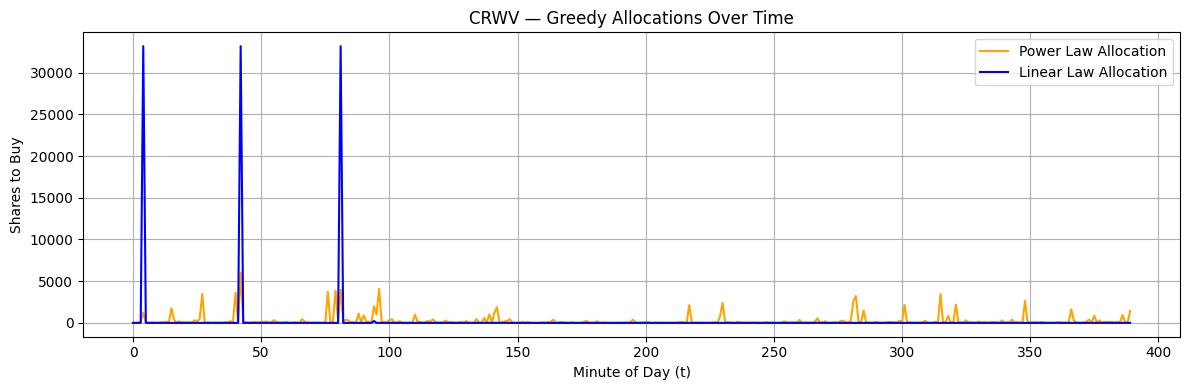


 Evaluating Greedy Strategy for FROG
 Power Law Market Impact: 24.68
 Linear Law Market Impact: 24.73
 Better Model: Power Law


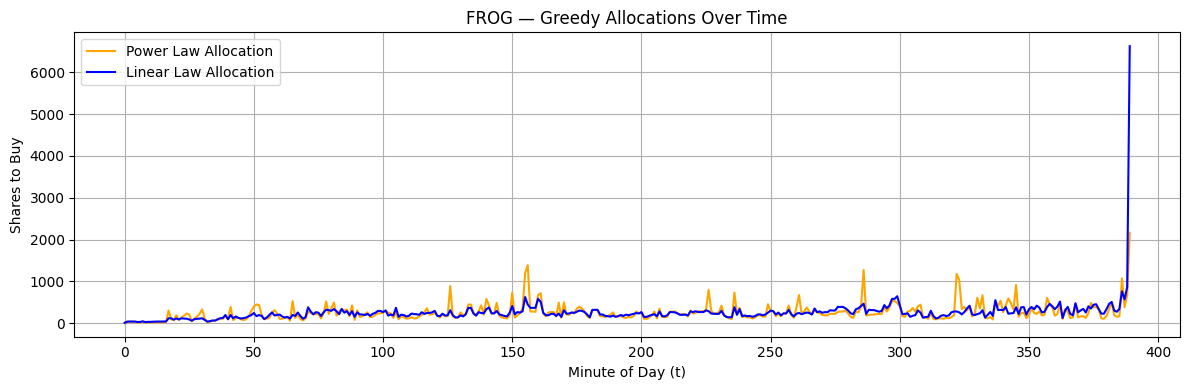


 Evaluating Greedy Strategy for SOUN
 Power Law Market Impact: 2.49
 Linear Law Market Impact: 2.18
 Better Model: Linear Law


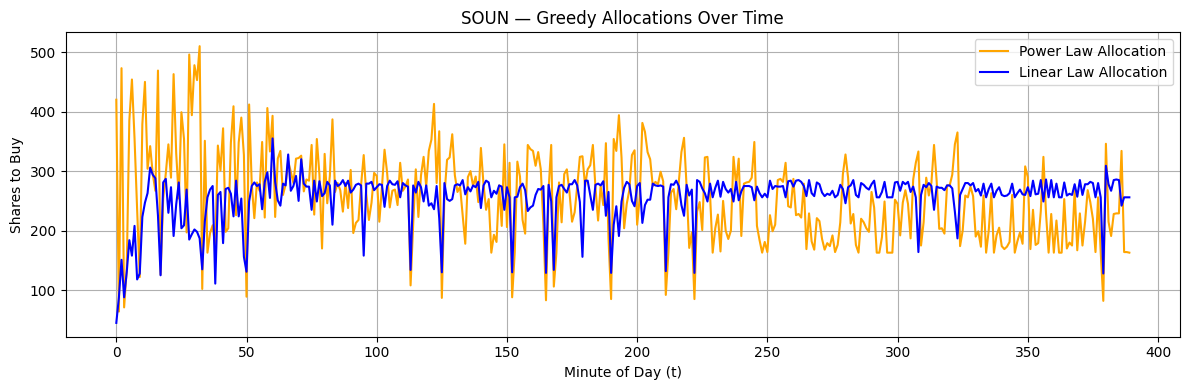

In [13]:
for ticker in tickers:
    print(f"\n Evaluating Greedy Strategy for {ticker}")
    
    df = pd.read_csv(f"{ticker}_model_coeffs_buy.csv").dropna()

    c_t = df["c_t"].values
    d_t = df["d_t"].values
    a_t = df["a_t"].values
    b_t = df["b_t"].values

    assert len(c_t) == 390, f"{ticker}: Expected 390 intervals"

    x_power = power_law_greedy_allocation(c_t, d_t, S)
    x_linear = linear_law_greedy_allocation(a_t, b_t, S)

    impact_power = compute_power_law_impact(x_power, c_t, d_t)
    impact_linear = compute_linear_law_impact(x_linear, a_t, b_t)

    print(f" Power Law Market Impact: {impact_power:,.2f}")
    print(f" Linear Law Market Impact: {impact_linear:,.2f}")
    better = "Power Law" if impact_power < impact_linear else "Linear Law"
    print(f" Better Model: {better}")

    plt.figure(figsize=(12, 4))
    plt.plot(x_power, label="Power Law Allocation", color="orange")
    plt.plot(x_linear, label="Linear Law Allocation", color="blue")
    plt.title(f"{ticker} — Greedy Allocations Over Time")
    plt.xlabel("Minute of Day (t)")
    plt.ylabel("Shares to Buy")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


## 14. Final Conclusion

In this project, I modeled temporary market impact for each 1-minute interval using two types of functions — **Linear** and **Power Law** — on three tickers: CRWV, FROG, and SOUN, for both buying and selling.

### Key Takeaways:

- **Power Law fits the slippage data better** (higher R²), especially for small trade sizes. This means it explains the observed slippage more accurately in many cases.
- But **Linear models usually result in lower total market impact**, especially when the total number of shares to trade (S) is large. This means they are often better for actual execution.
- So:  
  -  **Use Power Law** when you care about modeling the market accurately for **small trades**.  
  -  **Use Linear Law** when your goal is to **minimize total impact**, especially for **large orders**.
- This shows that a model with better fit (higher R²) doesn’t always give better execution results.
- Choosing the right model depends on both **trade size** and **execution goal** — not just the fit quality.

This method of modeling each minute separately and applying a greedy allocation algorithm helps reduce market impact in a simple, data-driven way.
